In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import resize
from tqdm.notebook import tqdm
import plotly.graph_objs as go
import plotly.io as pio
from matplotlib.colors import ListedColormap, to_rgba
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

In [2]:
dir_path = '../inteligencia_artificial/train/'
img_size = (224, 224)
classing_maps = []

In [3]:
class_mapping = {
    "Abyssinian": 0,
    "American Bobtail": 1,
    "doberman": 2,
    "yorkshire_terrier": 3
}

In [4]:
with open('../data/people_and_pet_minimized.json', 'r') as file:
    dataset = json.load(file)

In [5]:
classing_maps = []

In [6]:
files_names_images = []
for index, value in dataset.items():
    for pet in value:
        classing_maps.append({
            'image': pet['image'] + ".jpg",
            'class_name': pet['breed_name']
        })

In [7]:
X, y = [], []

In [8]:
for classing in tqdm(classing_maps):
    try:
        file_path = os.path.join(dir_path, classing['image'])
        img = imread(file_path)
        img = resize(img, img_size)
        X.append(img.flatten())
        y.append(class_mapping.get(classing['class_name'], -1))
    except Exception as ex:
        pass

  0%|          | 0/2236 [00:00<?, ?it/s]

No JPEG data found in image
Could not find codec parameters for stream 0 (Video: mjpeg, none(bt470bg/unknown/unknown)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
No JPEG data found in image
No JPEG data found in image
Could not find codec parameters for stream 0 (Video: mjpeg, none(bt470bg/unknown/unknown)): unspecified size
Consider increasing the value for the 'analyzeduration' (0) and 'probesize' (5000000) options
No JPEG data found in image


In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [11]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_tsne)

/home/joseph/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
colors = ListedColormap(sns.color_palette("hls", 10).as_hex())

In [37]:
class_labels = ["Abyssinian", "American Bobtail", "Doberman", "Yorkshire"]

In [38]:
data = np.hstack((X_tsne, labels.reshape(-1, 1)))
df = pd.DataFrame(data, columns=['x', 'y', 'label'])

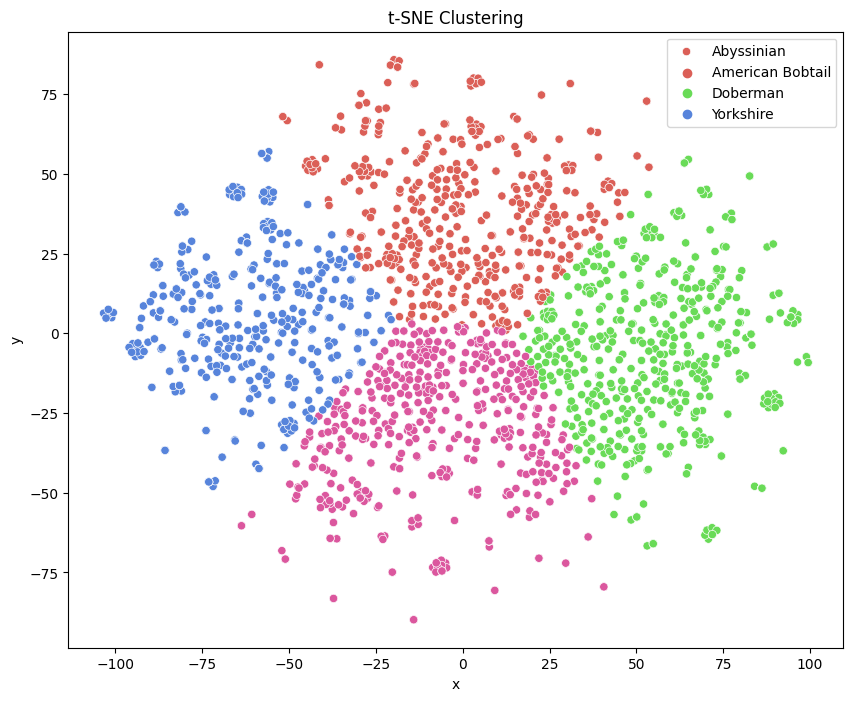

In [39]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', palette=colors, data=df)
plt.legend(labels=class_labels)
plt.title('t-SNE Clustering')
plt.show()

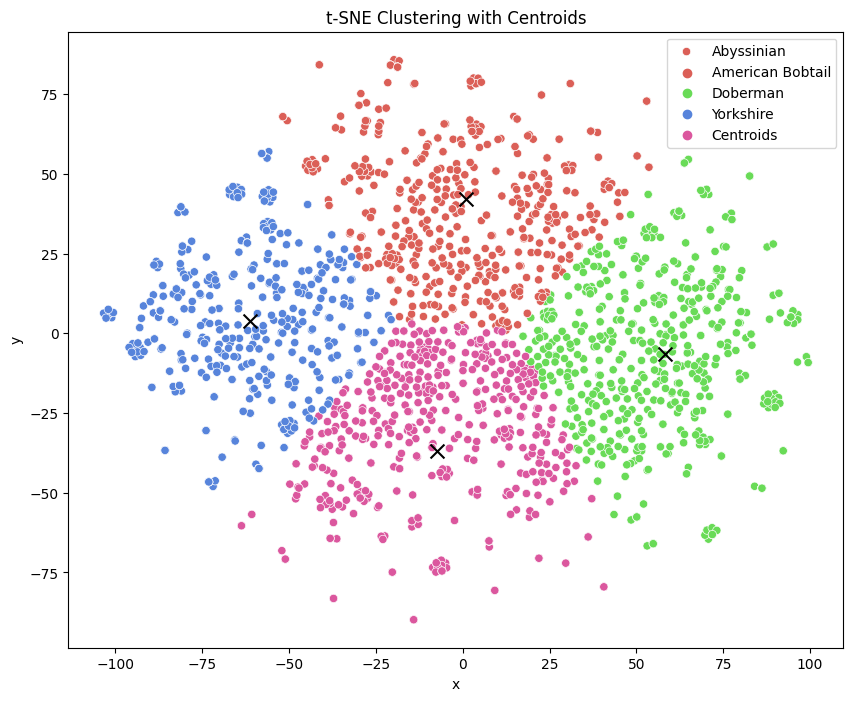

In [40]:
# Restante do código ...

# Obter coordenadas dos centróides
centroids = kmeans.cluster_centers_
centroid_labels = np.arange(len(centroids))

# Adicionar centróides ao DataFrame
centroids_df = pd.DataFrame(centroids, columns=['x', 'y'])
centroids_df['label'] = centroid_labels

# Concatenar dados dos pontos e centróides
plot_data = pd.concat([df, centroids_df])

# Plotagem do gráfico t-SNE com pontos e centróides
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', palette=colors, data=df)
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
plt.legend(labels=class_labels + ['Centroids'])
plt.title('t-SNE Clustering with Centroids')
plt.show()


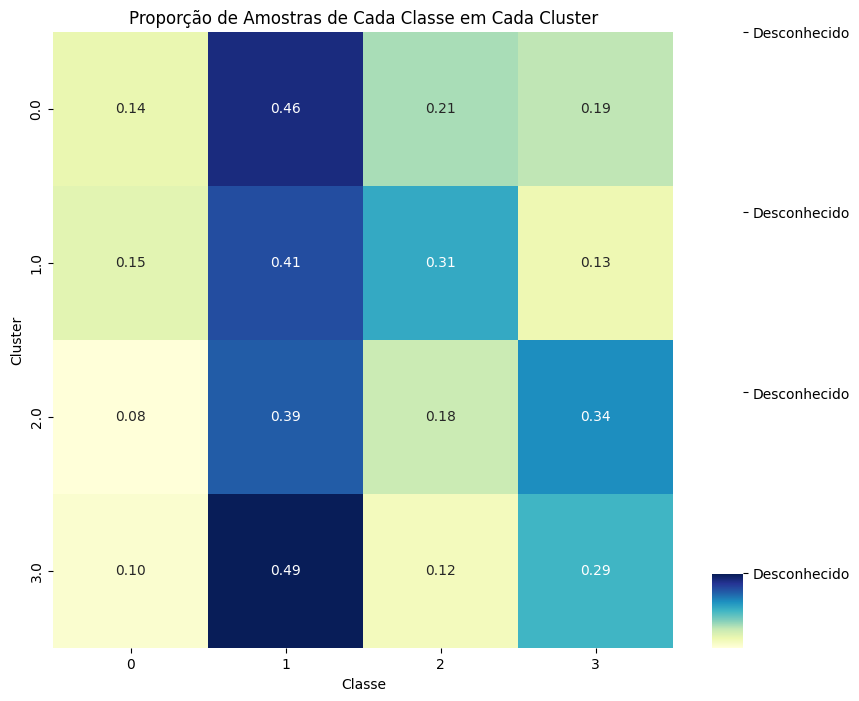

In [63]:
# Calcula a matriz de contagem das classes em cada cluster
class_counts = pd.crosstab(df['label'], y, rownames=['Cluster'], colnames=['Classe'])

# Calcula a proporção de amostras de cada classe em cada cluster
class_proportions = class_counts.div(class_counts.sum(axis=1), axis=0)

# Mapeia os rótulos das classes para os nomes correspondentes
class_labels = [class_mapping.get(cls, 'Desconhecido') for cls in class_counts.columns]

# Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(class_proportions, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Proporção de Amostras de Cada Classe em Cada Cluster')
plt.xlabel('Classe')
plt.ylabel('Cluster')

# Adiciona a legenda
cbar = plt.gca().collections[0].colorbar
cbar.set_ticks(np.arange(len(class_labels)) + 0.5)
cbar.set_ticklabels(class_labels)

plt.show()
